In [1]:
from PIL import Image

class RectScale(object):
    def __init__(self, height, width, interpolation=Image.BILINEAR):
        self.height = height
        self.width = width
        self.interpolation = interpolation

    def __call__(self, img):
        w, h = img.size
        if h == self.height and w == self.width:
            return img
        return img.resize((self.width, self.height), self.interpolation)

In [2]:
WIDTH = 224
HEIGHT = 224

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Original images in Market1501 dataset: 128 height x 64 width
basic_tfms = [RectScale(int(HEIGHT*1.1), int(WIDTH*1.1)),
              transforms.RandomCrop((HEIGHT, WIDTH)),
              transforms.RandomHorizontalFlip()]

data_transforms = {
    'train': transforms.Compose([
        *basic_tfms,
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        RectScale(HEIGHT, WIDTH),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [4]:
SEED = 15
VAL_SIZE = 0.25
BATCH_SIZE = 16

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
from dataset import get_images, get_targets, MarketAttr

images = get_images()
targets = get_targets()

for t in ['train', 'test']:
    idxs = np.arange(len(images[t]))
    np.random.seed(seed=15)
    np.random.shuffle(idxs)
    new_len = len(images[t]) // 200
    images[t] = images[t][idxs][:new_len]
    targets[t] = targets[t][idxs][:new_len]

# Split training set into training and validation
idxs = np.arange(len(images['train']))
train_idxs, val_idxs = train_test_split(idxs,
                                        test_size=VAL_SIZE,
                                        random_state=SEED)

datasets = {
    'train': MarketAttr(imgs=images['train'][train_idxs],
                        targets=targets['train'][train_idxs],
                        transform=data_transforms['train']),
    'val': MarketAttr(imgs=images['train'][val_idxs],
                      targets=targets['train'][val_idxs],
                      transform=data_transforms['train']),
    'test': MarketAttr(imgs=images['test'],
                       targets=targets['test'],
                       transform=data_transforms['test']),
}

dataloaders = {x: DataLoader(datasets[x],
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=12)
               for x in ['train', 'val', 'test']}

In [6]:
len(images['train'])

64

# Show a random tranformed image

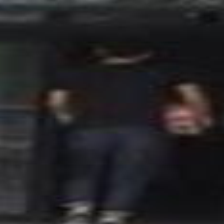

In [7]:
from PIL import Image
from random import randint
imgs = datasets['train'].imgs
im = Image.open(imgs[randint(0, len(imgs) - 1)])
transforms.Compose(basic_tfms)(im)

# Modify model to be compatible with dataset and problem statement

In [8]:
from torchvision.models import resnet34
from torch.nn import Linear, AvgPool2d, Sigmoid

model = resnet34(pretrained=True)

# Modify for aspect ratio
model.avgpool = AvgPool2d(kernel_size=((HEIGHT//224)*7, (WIDTH//224)*7), stride=1)

# There are 35 attributes per person
fc_in = model.fc.in_features
model.fc = Linear(fc_in, 35)

# Move model to GPU
model.cuda()
pass

# Train the model

In [9]:
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss
from datetime import datetime
from pathlib import Path
import numpy as np

SAVE_EVERY = 10
st = datetime.now().strftime('%Y-%m-%d_%Hu%M')

TRAIN_LOG = Path('log/train') / st
if not TRAIN_LOG.exists():
    TRAIN_LOG.mkdir(parents=True)
    
MODEL_CKPT_DIR = Path('cache/ckpts') / st
if not MODEL_CKPT_DIR.exists():
    MODEL_CKPT_DIR.mkdir(parents=True)


# The attributes are booleans, so append a sigmoid
# Note: sigmoid needs to be combined into the loss (e.g. using BCEWithLogitsLoss)
CRITERION = BCEWithLogitsLoss()
NUM_EPOCHS = 500


# Optimizer settings
BASE_LR = 1e-2
MOMENTUM = .9
OPTIMIZER = SGD([{'params': model.layer1.parameters(), 'lr': BASE_LR/9},
                 {'params': model.layer2.parameters(), 'lr': BASE_LR/9},
                 {'params': model.layer3.parameters(), 'lr': BASE_LR/3},
                 {'params': model.layer4.parameters(), 'lr': BASE_LR},
                 {'params': model.fc.parameters(), 'lr': BASE_LR}],
                momentum=MOMENTUM, nesterov=True)


# LR scheduler
CYCLE_LEN = 10
def lr_dec(epoch):
    return 0.5*(np.cos(np.pi*(epoch % CYCLE_LEN)/CYCLE_LEN) + 1)
SCHEDULER = LambdaLR(OPTIMIZER, lambda epoch: lr_dec(epoch))


In [10]:
from util.train import train
from tensorboardX import SummaryWriter

# TensorboardX writer
writer = SummaryWriter(str(TRAIN_LOG))

# Train the model
train(model=model,
      dataloaders=dataloaders,
      optimizer=OPTIMIZER,
      criterion=CRITERION,
      scheduler=SCHEDULER,
      num_epochs=NUM_EPOCHS,
      save_every=SAVE_EVERY,
      save_dir=MODEL_CKPT_DIR,
      writer=writer)

100%|██████████| 500/500 [25:57<00:00,  3.70s/it]
